In [2]:
# !pip install nilearn
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy
# !pip install scipy
# !pip install matplotlib

In [1]:
from nilearn import datasets, image, masking, plotting, regions
from nilearn.input_data import NiftiMasker
from sklearn.decomposition import PCA
from nilearn.image import new_img_like
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import pickle
import json
import math

c:\Users\david\anaconda3\envs\Brain\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# 1. Load and visualize data

## Text data

In [2]:
# Load text chuncks for all languages
file_path_T1 = './text_data/CN_chunk_data_chunk_size_2.pickle'
file_path_T2 = './text_data/EN_chunk_data_chunk_size_2.pickle'
file_path_T3 = './text_data/FR_chunk_data_chunk_size_2.pickle'
with open(file_path_T1, 'rb') as f:
            text_chunks_CN = pickle.load(f)
with open(file_path_T2, 'rb') as f:
            text_chunks_EN = pickle.load(f)
with open(file_path_T3, 'rb') as f:
            text_chunks_FR = pickle.load(f)

In [3]:
print(text_chunks_CN)
print(text_chunks_EN)
print(text_chunks_FR)

[[{'sentences': '当 我 还 只有 六 岁 的 时候 在 一 本 描写 原始 森林 的 名 叫 真实 的 故事 的 书 中 看到 了 一 幅 精彩 的 插画. 画 的 是 一 条 蟒蛇 正在 吞食 一 只 大 野兽. ', 'onset': 0.0, 'offset': 11.3, 'section': 1}, {'sentences': '页头 上 就 是 那 幅 画 的 摹本. 这 本 书 中 写道 这些 蟒蛇 把 它们 的 猎获物 不 加 咀嚼 地 囫囵 吞 下 尔后 就 不 能 再 动弹 了. ', 'onset': 12.11, 'offset': 22.09, 'section': 1}, {'sentences': '它们 就 在 长长 的 六 个 月 的 睡眠 中 消化 这些 食物. 当时 我 对 丛林 中 的 奇遇 想 得 很 多. ', 'onset': 22.83, 'offset': 30.03, 'section': 1}, {'sentences': '于是 我 也 用 彩色 铅笔 画 出 了 我 的 第一 幅 图画. 我 的 第一 号 作品 它 是 这样 的. ', 'onset': 30.68, 'offset': 37.38, 'section': 1}, {'sentences': '我 把 我 的 这 幅 杰作 拿 给 大人 看. 我 问 他们 我 的 画 是 不 是 叫 他们 害怕. ', 'onset': 38.73, 'offset': 44.0, 'section': 1}, {'sentences': '他们 回答 我 说 害怕 一 顶 帽子 有 什么 可怕 的. 我 画 的 不 是 帽子 是 一 条 巨蟒 在 消化 着 一 头 大象. ', 'onset': 44.89, 'offset': 54.39, 'section': 1}, {'sentences': '既然 大人们 不 能够 理解 于是 我 又 把 巨蟒 肚子 里 的 情况 画 了 出来 以便 让 大人们 能够 看 懂. 这些 大人 总是 需要 解释. ', 'onset': 55.23, 'offset': 64.53, 'section': 1}, {'sentences': '我 的 第二 号 作品 是 这样 的. 大人们 劝 我 

## FMRI human data

For each subject, we have a timeseries of FMRI scans

In [4]:
# Load a fmri file from a subjects for each language
file_path_F1 = '../FMRI/derivatives/sub-EN057/func/sub-EN057_task-lppEN_run-15_space-MNIColin27_desc-preproc_bold.nii.gz'
file_path_F2 = '../FMRI/derivatives/sub-CN002/func/sub-CN002_task-lppCN_run-04_space-MNIColin27_desc-preproc_bold.nii.gz'
file_path_F3 = '../FMRI/derivatives/sub-FR001/func/sub-FR001_task-lppFR_run-01_space-MNIColin27_desc-preproc_bold.nii.gz'
nii_img_1  = image.load_img(file_path_F1)
nii_data_EN = nii_img_1.get_fdata()
nii_img_2  = image.load_img(file_path_F2)
nii_data_CN = nii_img_2.get_fdata()
nii_img_3  = image.load_img(file_path_F3)
nii_data_FR = nii_img_3.get_fdata()

We can visualize the brain activity averaged across time

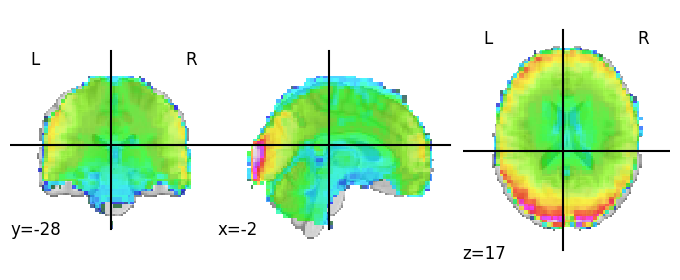

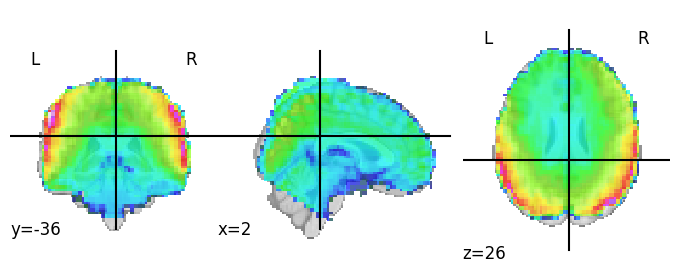

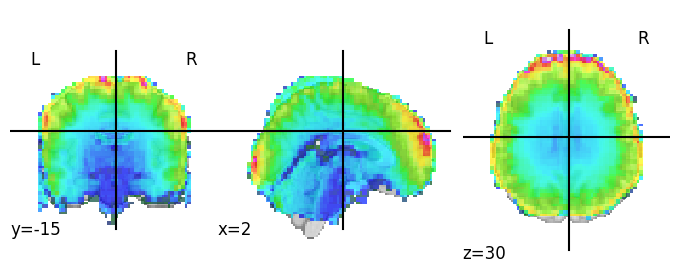

In [5]:
func_mean1 = image.mean_img(nii_img_1)
display_EN = plotting.plot_roi(func_mean1)

func_mean2 = image.mean_img(nii_img_2)
display_CN = plotting.plot_roi(func_mean2)

func_mean3 = image.mean_img(nii_img_3)
display_FR = plotting.plot_roi(func_mean3)

We can look up the units the fMRI timeseries and theirs size:

In [6]:
# units of the dimensions
print(nii_img_1.header.get_zooms())
print(nii_img_1.header.get_xyzt_units())

(2.0, 2.0, 2.0, 2.0)
('mm', 'sec')


In [7]:
# dimension size of the fmri scans for different languages
print(nii_data_EN.shape)
print(nii_data_CN.shape)
print(nii_data_FR.shape)
print('-> Voxels are the same across languages but number of timesteps differs')

(73, 90, 74, 282)
(73, 90, 74, 283)
(73, 90, 74, 309)
-> Voxels are the same across languages but number of timesteps differs


## Model representation data

For the models we load hidden states from a mulilingual XML-R model. The hidden states were obtained by giving the models blocks of two sentences and taking the hidden states of all layers for every stimuli

In [8]:
# Load model representations for all languages
file_path_M1 = './text_data/CN_hidden_states_chunk_size_2.pickle'
file_path_M2 = './text_data/EN_hidden_states_chunk_size_2.pickle'
file_path_M3 = './text_data/FR_hidden_states_chunk_size_2.pickle'

with open(file_path_M1, 'rb') as f:
            hidden_activations_CN = pickle.load(f)
            
# These files are about 4 GB, so depending on your Laptop loading all of them might run out of memory
# with open(file_path_M2, 'rb') as f:
#             hidden_activations_EN = pickle.load(f)
# with open(file_path_M3, 'rb') as f:
#             hidden_activations_FR = pickle.load(f)

c:\Users\david\anaconda3\envs\Brain\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# dimension size of the model representations for different languages
print('Dimensions: [sections, layers, chunks, max_sent_length, hidden_dim]')
print(len(hidden_activations_CN), hidden_activations_CN[0].shape)
# print(len(hidden_activations_EN), hidden_activations_EN[0].shape)
# print(len(hidden_activations_FR), hidden_activations_FR[0].shape)
print('-> Important Note: Number of sentences/chunks is different across languages')

Dimensions: [sections, layers, chunks, max_sent_length, hidden_dim]
9 torch.Size([13, 72, 150, 768])
-> Important Note: Number of sentences/chunks is different across languages


## Align model representations and FMRI scans

To be able to compare the subjects brain scans to the models we need to allign them. We do this by averaging the fMRI scans that belong to the time window of a text block. For this we here sort fMRI indeces into their respective blocks.

In [12]:
def text2idx(sects, delay = 5, window = 0) :
  for sect in sects :
    for sent in sect : 
      onset = int((sent['onset'] + delay - window)/2)
      offset = math.ceil((sent['offset'] + delay + window)/2)
      sent['idx'] = slice(onset, offset)
  return sects

text_bins_CN = text2idx(text_chunks_CN)
text_bins_EN = text2idx(text_chunks_EN)
text_bins_FR = text2idx(text_chunks_FR)

In [13]:
print(text_bins_EN)
print(text_bins_FR)
print(text_bins_CN)

[[{'sentences': 'once when i was six years old i saw a magnificent picture in a book about the primeval forest called real life stories. it showed a boa constrictor swallowing a wild animal. ', 'onset': 0.113, 'offset': 12.416, 'section': 1, 'idx': slice(2, 9, None)}, {'sentences': 'here is a copy of the drawing. it said in the book boa constrictors swallow their prey whole without chewing then they are not able to move and they sleep for the six months it takes for digestion. ', 'onset': 13.144, 'offset': 26.339, 'section': 1, 'idx': slice(9, 16, None)}, {'sentences': 'so i thought a lot about the adventures of the jungle and in turn i managed with a colored pencil to make my first drawing my drawing number one. it looked like this. ', 'onset': 27.292, 'offset': 38.326, 'section': 1, 'idx': slice(16, 22, None)}, {'sentences': 'i showed my masterpiece to the grownups and i asked them if my drawing frightened them. they answered me why would anyone be frightened by a hat. ', 'onset': 39

# 2. Data analysis functions

Next we define our two main functions. "rsa_function" computes the RSA matrices for both fMRI data and model representations. We can specify the number of principle components we would like from the fmri scans and the layer for the models. Further we can interpolate the timeserieses to any size that we want. The selfsimilarity of the timesteps is computed by cosine distance. "rsa_correlation()" computes the pearson correlation of the upper triangle (without the 5 main diagonals) between two RSA matrices and outputs a correlation values and a p_values.

## RSA function

In [16]:
def rsa_function(file_path, data_type='FMRI', N_components=280, layer=-1, text_bins=None, interp = False, interp_size = 61):

    '''
    Compute the sen by sen RSA with cosine similarity
    '''

    if data_type == 'FMRI':

        nii_img  = image.load_img(file_path)

        if text_bins == None:

            nii_data = nii_img.get_fdata()
            time_series = nii_data.transpose(3,0,1,2).reshape(nii_data.shape[3],-1)

        else:

            # extract and mean the fmri scans for each sentence chunck
            nii_data = np.array([image.mean_img(image.index_img(nii_img_1, sent['idx'])).get_fdata() for sent in text_bins[0]])
            time_series = nii_data.reshape(nii_data.shape[0],-1)

        if interp:
            # interpolation
            # Calculate the interpolation factor
            interp_factor = interp_size / len(time_series)

            # Generate indices for interpolation
            indices = np.arange(interp_size) / interp_factor

            # Perform linear interpolation
            RSA_interp = np.empty((interp_size, time_series.shape[1]))
            for dim in range(time_series.shape[1]):
                RSA_interp[:, dim] = np.interp(indices, np.arange(len(time_series)), time_series[:, dim])

            data_matrix = RSA_interp

        N_components = min(N_components, len(data_matrix))
        pca = PCA(N_components)
        pca.fit(data_matrix)
        # print('Explained variance:', pca.explained_variance_ratio_)

        data_matrix = pca.transform(data_matrix)

    elif data_type == 'AI':
        # Expected input: torch.Size([93, 59, 768])
        with open(file_path, 'rb') as f:
            hidden_activations = pickle.load(f)

        # input shape is [sections, layers, chunks, words, hidden_dim]
        h_a = hidden_activations[0][layer] # last hidden_activations for first section

        hidden_activations = h_a.numpy()
        data_matrix = np.mean(hidden_activations, axis=1)

        if interp:
            # interpolation
            # Calculate the interpolation factor
            interp_factor = interp_size / len(data_matrix)

            # Generate indices for interpolation
            indices = np.arange(interp_size) / interp_factor

            # Perform linear interpolation
            RSA_interp = np.empty((interp_size, data_matrix.shape[1]))
            for dim in range(data_matrix.shape[1]):
                RSA_interp[:, dim] = np.interp(indices, np.arange(len(data_matrix)), data_matrix[:, dim])

            data_matrix = RSA_interp

    # discard first 8 seconds to account for FMRI warmup
    data_matrix = data_matrix[4:,:]

    # compute the RSA as sentence by sentence cosine sim matrix
    RSA = sp.spatial.distance.cdist(data_matrix, data_matrix, metric='cosine')
    RSA = RSA/RSA.max()

    return RSA

## Pearson correlation function

In [17]:
def rsa_correlation(RSA_1, RSA_2):
    '''
    computes the correlation between to RSA matrizes with pearson correlation
    '''
    RSA_upper_1 = np.triu(RSA_1 + 1e-15, 5)
    RSA_upper_2 = np.triu(RSA_2 + 1e-15, 5)
    RSA_up_1 = RSA_upper_1[RSA_upper_1 !=0]
    RSA_up_2 = RSA_upper_2[RSA_upper_2 !=0]

    Corr = sp.stats.pearsonr(RSA_up_1.flatten(), RSA_up_2.flatten())

    return Corr

# 3. Single pair analysis

## FMRI - FMRI

Using the functions defined above we can for example compute the correlation between the fMRI scans of a English and a Chinese speaker, while they listen to the same text but in their respective language.

In [18]:
RSA_EN_F1 = rsa_function(file_path_F1, text_bins=text_bins_EN, interp=True, interp_size=786)
RSA_CN_F1 = rsa_function(file_path_F2, text_bins=text_bins_CN, interp=True, interp_size=786)

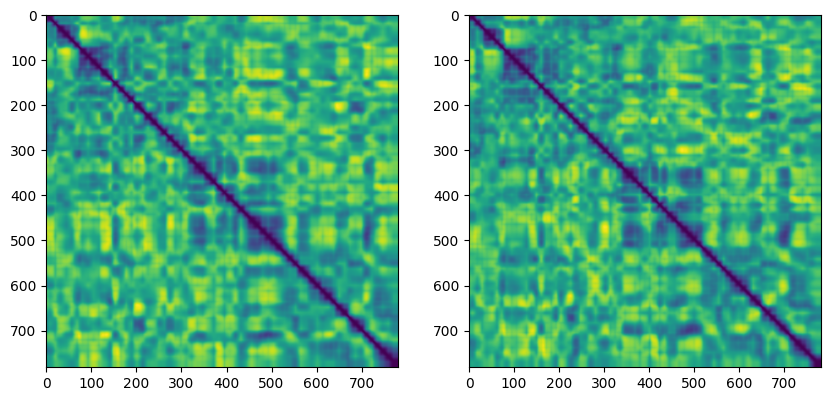

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(RSA_EN_F1)
ax[1].imshow(RSA_CN_F1)

### RSA by RSA correlation

In [20]:
Corr = rsa_correlation(RSA_EN_F1, RSA_CN_F1)
print(Corr)

PearsonRResult(statistic=0.487136451548199, pvalue=0.0)


The correlation between these two subject is really high (48.7 %) with a significant pvalue (pvalue < 0.05).

## Model - Model

We can do the same for the two layers. In this case the last layer of the model receving Chinese text and the last layer of the model receving English text.

In [50]:
RSA_EN_M1 = rsa_function('./text_data/EN_hidden_states_chunk_size_2.pickle', 'AI', interp=True, interp_size=61)

In [51]:
RSA_CN_M1 = rsa_function('./text_data/CN_hidden_states_chunk_size_2.pickle', 'AI', interp=True, interp_size=61)

Text(0.5, 1.0, 'CN')

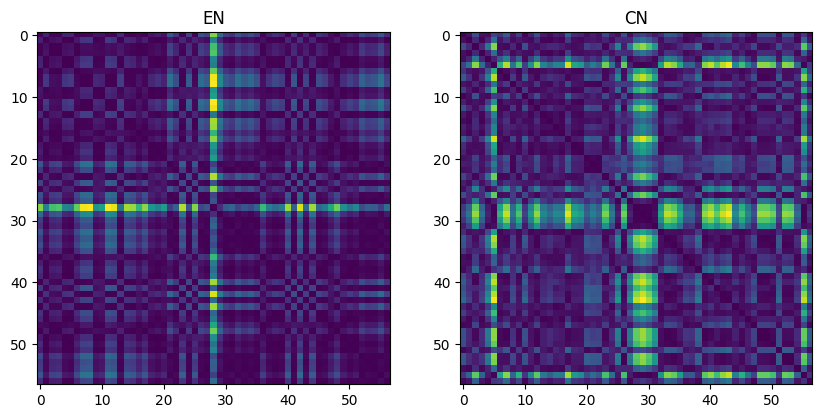

In [52]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(RSA_EN_M1)
ax[0].set_title('EN')
ax[1].imshow(RSA_CN_M1)
ax[1].set_title('CN')

In [53]:
# pearson correlation
Corr_EN_CN = rsa_correlation(RSA_EN_M1, RSA_CN_M1)

print(f'Correlation between EN and CN for last hidden represntations: {Corr_EN_CN}')

Correlation between EN and CN for last hidden represntations: PearsonRResult(statistic=0.267866762992627, pvalue=4.500912284912086e-24)


The correlation is not as high as that of the two brain represenations but still fairly high (26.8 %) and significant.

## FMRI - Model

We can also take the correlation between a brain scan RSA matrix and a model layer RSA matrix.

In [59]:
# Load a fmri file from a subjects for each language
RSA_EN_F1 = rsa_function(file_path_F1, text_bins=text_bins_EN, interp=True, interp_size=786)
RSA_EN_M1 = rsa_function('./text_data/EN_hidden_states_chunk_size_2.pickle', 'AI', interp=True, interp_size=786)

Text(0.5, 1.0, 'Model RSA')

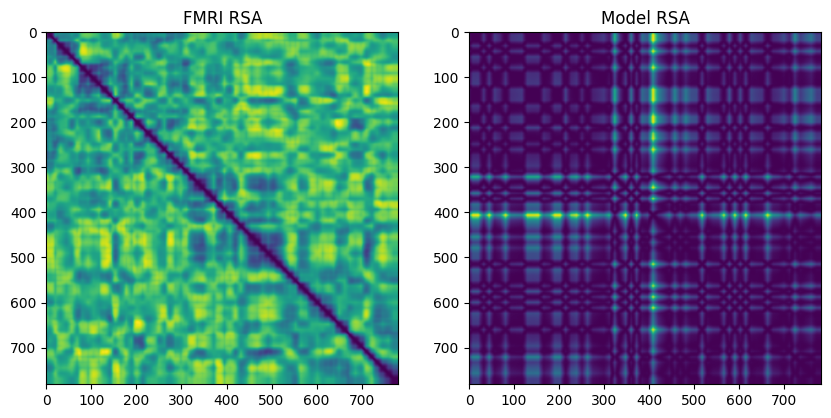

In [60]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(RSA_EN_F1)
ax[0].set_title('FMRI RSA')
ax[1].imshow(RSA_EN_M1)
ax[1].set_title('Model RSA')

In [61]:
Corr_F1_M1 = rsa_correlation(RSA_EN_F1, RSA_EN_M1)
print(f'Correlation between EN for last hidden represntations and EN FMRI scan: {Corr_F1_M1}')

Correlation between EN for last hidden represntations and EN FMRI scan: PearsonRResult(statistic=0.07961531605175935, pvalue=0.0)


This has a much lower (8.0 %) correlation but is still significant.

# 4. Analysis of all subjects

Now we compute the correlation values across model layers and human subjects. If available we can load precomputed RSAs. If they are not available set the boolean precompute to false to compute them now. For a discussion of the results you see here, check out our paper linked in the ReadME.

In [21]:
precompute = True

## FMRI - FMRI

### Compute the RSAs for each subject if not already available

In [63]:
if precompute == False:

    # Get the paths for the first scan for each subject
    scans = {}
    path_to_data = f'../FMRI/derivatives/'
    path_to_subjects = [it.path for it in os.scandir(path_to_data)]
    for subject_path in path_to_subjects:
        # extract name of the subject
        subject = subject_path[subject_path.find('sub-') + 4 : subject_path.find('sub-') + 9]
        # take the first scan of the subject
        path_to_scans = [it.path for it in os.scandir(subject_path + '/func/')]
        scans[subject] = path_to_scans[0]
    print(f'Number of subjects: {len(scans)}')

    # should take over an hour (appr. 40 sec per subj, n_subj=111)
    RSAs = {}
    for i, subject in enumerate(scans.keys()):
        if i % 10 == 0: print(f'Running subject {i}')
        try:
            RSAs[subject] = rsa_function(scans[subject], 'FMRI', interp=True, interp_size=786)
        except EOFError:
            print(scans[subject])
            continue

Number of subjects: 111
Running subject 0
Running subject 10
../FMRI/derivatives/sub-CN018/func/sub-CN018_task-lppCN_run-05_space-MNIColin27_desc-preproc_bold.nii.gz
../FMRI/derivatives/sub-CN019/func/sub-CN019_task-lppCN_run-05_space-MNIColin27_desc-preproc_bold.nii.gz
Running subject 20
Running subject 30
Running subject 40
Running subject 50
Running subject 60
Running subject 70
Running subject 80
Running subject 90
Running subject 100
Running subject 110


In [64]:
if precompute == False:

    RSAs_list = {}
    for key, value in RSAs.items():
        RSAs_list[key] = value.tolist()

    with open("./RSAs/RSAs_FMRI_big.json", "w") as f:
        json.dump(RSAs_list, f)

### Load RSAs and compute pairwise pearson correlation

In [65]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_FMRI_big.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs = {}
for key, value in RSAs_list.items():
    RSAs[key] = np.array(value)

In [66]:
num_visualize = 100
vis = False

if vis == True:
    count = 0
    j = 0
    fig, ax = plt.subplots(10,10, figsize=(20,20))
    for i, (key, value) in enumerate(RSAs.items()):
        j = i % 10
        i = i // 10
        ax[j][i].imshow(value)
        ax[j][i].set_title(f'{round(np.mean(value[30:,30:]),2)}')
        count += 1
        if count == num_visualize: break

In [73]:
RSAs['CN001'].shape

(782, 782)

In [67]:
N_subjects = len(RSAs) 
Correlations = np.zeros((N_subjects, N_subjects))
pvalues = np.zeros((N_subjects, N_subjects))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs.keys()):
    for j, subj_b in enumerate(RSAs.keys()):
        rsa_1 = RSAs[subj_a]
        rsa_2 = RSAs[subj_b]
        min_time = min(len(rsa_1), len(rsa_2))
        Correlations[i,j], pvalues[i,j] = rsa_correlation(rsa_1[:min_time, :min_time], rsa_2[:min_time, :min_time])
        print(f"Pearson correlation coefficient between {subj_a} and {subj_b}: {Correlations[i,j]}, pvalue: {pvalues[i,j]}")

Pearson correlation coefficient between CN001 and CN001: 1.0, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN002: 0.09967805428275675, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN003: 0.25775891041855425, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN004: 0.1346062010245797, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN005: 0.5771657989257098, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN006: 0.13223686807173554, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN007: 0.11602547234477427, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN008: 0.03952874882356396, pvalue: 8.526398684332591e-105
Pearson correlation coefficient between CN001 and CN009: 0.2860770077634637, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN010: 0.11091260254871979, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN011: 0.6050564710266609, pvalue: 0.0
Pearson cor

This is the results for between human subjcets. We can see several artefacts which we remove bellow.

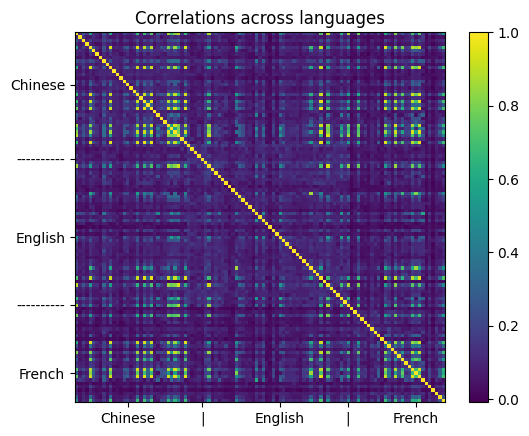

In [68]:
plt.figure(42)
plt.title('Correlations across languages')
plt.xticks([15, 37, 60 ,80, 100], ['Chinese', '|', 'English', '|', 'French'])
plt.yticks([15, 37, 60 ,80, 100], ['Chinese', '----------', 'English', '----------', 'French'])
plt.imshow(Correlations)
plt.colorbar()

### Remove Artefacts

In [86]:
treshold = 0.35
removed_subjects = []

RSAs_FMRI_filtered_1 = {}
for i, (key, value) in enumerate(RSAs.items()):
    if round(np.mean(value[:390,:390]),2) > 0.35:
        RSAs_FMRI_filtered_1[key] = value
    else: removed_subjects.append(key)
len(RSAs_FMRI_filtered_1)

91

In [87]:
treshold = 0.35

RSAs_FMRI_filtered = {}
for i, (key, value) in enumerate(RSAs_FMRI_filtered_1.items()):
    if round(np.mean(value[390:,390:]),2) > 0.35:
        RSAs_FMRI_filtered[key] = value
    else: removed_subjects.append(key)
len(RSAs_FMRI_filtered)

88

In [88]:
if precompute == False:

    RSAs_list = {}
    for key, value in RSAs_FMRI_filtered.items():
        RSAs_list[key] = value.tolist()

    with open("./RSAs/RSAs_FMRI_big_filterd.json", "w") as f:
        json.dump(RSAs_list, f)

In [89]:
print(f'Removed subjects {removed_subjects}')

Removed subjects ['CN001', 'CN005', 'CN011', 'CN022', 'CN024', 'CN026', 'CN031', 'CN033', 'CN034', 'CN037', 'EN064', 'EN104', 'EN106', 'EN115', 'FR011', 'FR014', 'FR019', 'FR022', 'EN100', 'FR016', 'FR020']


In [90]:
num_visualize = 90
vis = False

if vis == True:
    count = 0
    j = 0
    fig, ax = plt.subplots(10,10, figsize=(20,20))
    for i, (key, value) in enumerate(RSAs_FMRI_filtered.items()):
        j = i % 10
        i = i // 10
        ax[j][i].imshow(value)
        ax[j][i].set_title(key)
        count += 1
        if count == num_visualize: break

In [91]:
N_subjects = len(RSAs_FMRI_filtered) 
Correlations_filterd = np.zeros((N_subjects, N_subjects))
pvalues_filterd = np.zeros((N_subjects, N_subjects))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs_FMRI_filtered.keys()):
    for j, subj_b in enumerate(RSAs_FMRI_filtered.keys()):
        rsa_1 = RSAs[subj_a]
        rsa_2 = RSAs[subj_b]
        min_time = min(len(rsa_1), len(rsa_2))
        Correlations_filterd[i,j], pvalues_filterd[i,j] = rsa_correlation(rsa_1[:min_time, :min_time], rsa_2[:min_time, :min_time])
        print(f"Pearson correlation coefficient between {subj_a} and {subj_b}: {Correlations_filterd[i,j]}, pvalue: {pvalues_filterd[i,j]}")

Pearson correlation coefficient between CN002 and CN002: 1.0, pvalue: 0.0
Pearson correlation coefficient between CN002 and CN003: 0.14052024596240206, pvalue: 0.0
Pearson correlation coefficient between CN002 and CN004: 0.05601990057783069, pvalue: 1.3115314578417177e-208
Pearson correlation coefficient between CN002 and CN006: 0.11867904846093064, pvalue: 0.0
Pearson correlation coefficient between CN002 and CN007: 0.0703458168493168, pvalue: 0.0
Pearson correlation coefficient between CN002 and CN008: 0.03782190640799946, pvalue: 4.246745325145766e-96
Pearson correlation coefficient between CN002 and CN009: 0.16581816049437456, pvalue: 0.0
Pearson correlation coefficient between CN002 and CN010: 0.10106531818201636, pvalue: 0.0
Pearson correlation coefficient between CN002 and CN013: 0.04447165110213708, pvalue: 3.8042998419094555e-132
Pearson correlation coefficient between CN002 and CN014: 0.088102857719556, pvalue: 0.0
Pearson correlation coefficient between CN002 and CN015: 0.04

In [92]:
EN_idx, CN_idx, FR_idx = [], [], []
for i, key in enumerate(RSAs_FMRI_filtered.keys()):
    if key.find('CN') != -1: CN_idx.append(i)
    elif key.find('EN') != -1: EN_idx.append(i)
    elif key.find('FR') != -1: FR_idx.append(i)

print(f'Number of CN: {len(CN_idx)}, Number of EN: {len(EN_idx)}, Number of FR: {len(FR_idx)}')

Number of CN: 23, Number of EN: 43, Number of FR: 22


This is the results for between human subjcets without artefacts.

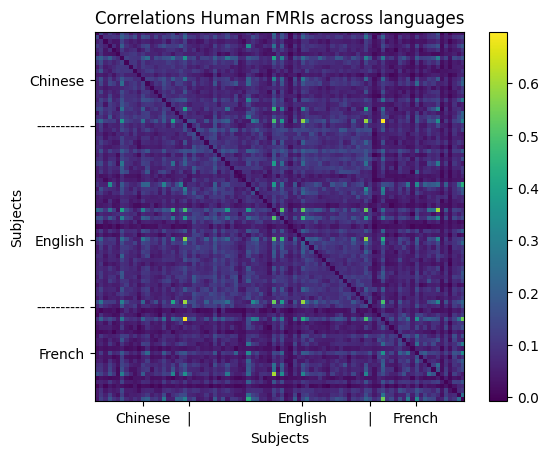

In [164]:
fig, ax = plt.subplots()
ax.set_title('Correlations Human FMRIs across languages')
ax.set_xticks([11, 22, 49 ,65, 76], ['Chinese', '|', 'English', '|', 'French'])
ax.set_yticks([11, 22, 49 ,65, 76], ['Chinese', '----------', 'English', '----------', 'French'])
ax.set_xlabel('Subjects')
ax.set_ylabel('Subjects')
for i in range(len(Correlations_filterd)): Correlations_filterd[i,i] = 0
im = ax.imshow(Correlations_filterd, cmap='viridis')
cbar = plt.colorbar(im)

In [94]:
mean_values_FMRI = []
for x,y in [[0,22], [23,65], [66,87]]:
    for m,n in [[0,22], [23,65], [66,87]]:
        mean_values_FMRI.append(np.mean(Correlations_filterd[x:y,m:n]))
mean_values_FMRI = np.array(mean_values_FMRI).reshape(3,3)


In [95]:
df_FMRI = pd.DataFrame(mean_values_FMRI, index=['Chinese', 'English', 'French'], columns=['Chinese', 'English', 'French'])
print(df_FMRI)

          Chinese   English    French
Chinese  0.094855  0.083215  0.065654
English  0.083215  0.097050  0.068248
French   0.065654  0.068248  0.079872


## Model - Model

### Compute the RSAs for each layer and language if not already available

In [96]:
if precompute == False:

    # compute the RSAs for all languages and all layers (first section only)
    languages = ['EN','CN', 'FR']
    RSAs_models = {}
    for lang in languages:
        file_path = f'./text_data/{lang}_hidden_states_chunk_size_2.pickle'
        for layer in range(13):
            key = lang + '_' + str(layer)
            RSAs_models[key] = rsa_function(file_path, 'AI', layer=layer, interp=True, interp_size=786)

In [97]:
if precompute == False:

    RSAs_list = {}
    for key, value in RSAs_models.items():
        RSAs_list[key] = value.tolist()

    with open("./RSAs/RSAs_Model_big.json", "w") as f:
        json.dump(RSAs_list, f)

### Load RSAs and compute pairwise pearson correlation

In [98]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_Model_big.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs_models = {}
for key, value in RSAs_list.items():
    RSAs_models[key] = np.array(value)

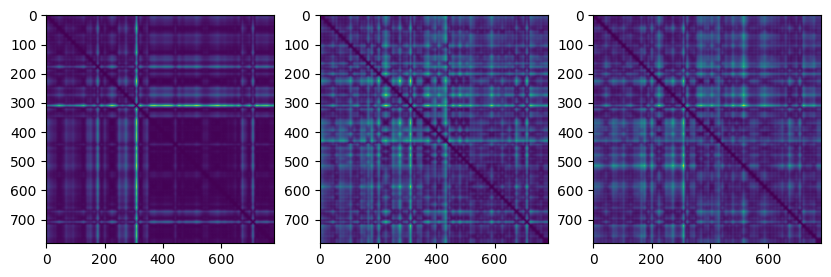

In [99]:
num_visualize = 3

count = 0
fig, ax = plt.subplots(1,num_visualize, figsize=(10,10))
for i, (key, value) in enumerate(RSAs_models.items()):
    ax[i].imshow(value)
    count += 1
    if count == num_visualize: break

In [100]:
languages = ['EN','CN', 'FR']
N_RSAs = len(RSAs_models)
Model_Correlations = np.zeros((N_RSAs, N_RSAs))
Model_pvalues = np.zeros((N_RSAs, N_RSAs))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs_models.keys()):
    for j, subj_b in enumerate(RSAs_models.keys()):
        rsa_1 = RSAs_models[subj_a]
        rsa_2 = RSAs_models[subj_b]
        Model_Correlations[i,j], Model_pvalues[i,j] = rsa_correlation(rsa_1, rsa_2)
        l1_idx = int(i / 13)
        l2_idx = int(j / 13)
        layer1_idx = i % 13
        layer2_idx = j % 13
        print(f"Pearson correlation coefficient between {languages[l1_idx]} {layer1_idx} and {languages[l2_idx]} {layer2_idx}: {Model_Correlations[i,j]}, pvalue: {Model_pvalues[i,j]}")

Pearson correlation coefficient between EN 0 and EN 0: 0.9999999999999927, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 1: 0.6793902077540485, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 2: 0.7016325424169693, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 3: 0.6531099306484757, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 4: 0.44024734171409485, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 5: 0.2008048222846744, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 6: 0.15213718709073332, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 7: 0.06535920111618859, pvalue: 2.360348884327774e-283
Pearson correlation coefficient between EN 0 and EN 8: 0.055871860442231115, pvalue: 1.619997904819601e-207
Pearson correlation coefficient between EN 0 and EN 9: 0.02580709890246606, pvalue: 1.0503851399277949e-45
Pearson correlation coefficient between EN 0 and EN 10: 0.004638790

This is the results for between model layers.

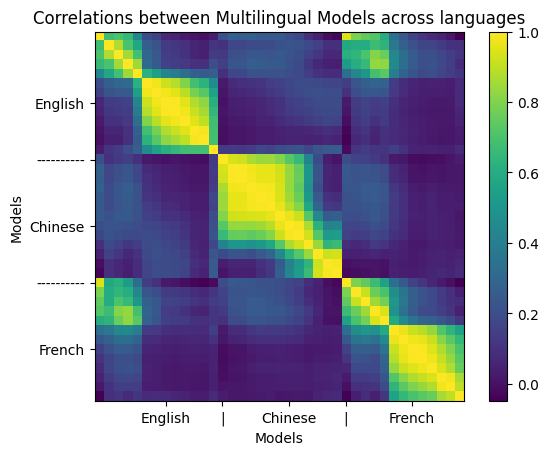

In [166]:
fig, ax = plt.subplots()
ax.set_title('Correlations between Multilingual Models across languages')
ax.set_xticks([7, 13, 20, 26, 33], ['English', '|', 'Chinese', '|', 'French'])
ax.set_yticks([7, 13, 20, 26, 33], ['English', '----------', 'Chinese', '----------', 'French'])
ax.set_xlabel('Models')
ax.set_ylabel('Models')
ax.imshow(Model_Correlations)
im = ax.imshow(Model_Correlations, cmap='viridis')
cbar = plt.colorbar(im)

In [102]:
mean_values_Model = []
for x,y in [[0,12], [13,25], [26,38]]:
    for m,n,  in [[0,12], [13,25], [26,38]]:
        mean_values_Model.append(np.mean(Model_Correlations[x:y,m:n]))
mean_values_Model = np.array(mean_values_Model).reshape(3,3)

In [103]:
df_Model = pd.DataFrame(mean_values_Model, index=['English', 'Chinese', 'French'], columns=['English', 'Chinese', 'French'])
print(df_Model)

          English   Chinese    French
English  0.527238  0.127026  0.214610
Chinese  0.127026  0.704803  0.094395
French   0.214610  0.094395  0.565435


## FMRI - Model

In [105]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_FMRI_big_filterd.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs_FMRI = {}
for key, value in RSAs_list.items():
    RSAs_FMRI[key] = np.array(value)

In [106]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_Model_big.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs_Model = {}
for key, value in RSAs_list.items():
    RSAs_Model[key] = np.array(value)

### Plot subjects by Model layers

In [107]:
N_subjects = len(RSAs_FMRI) 
N_layers = len(RSAs_Model) 
F_M_Correlations = np.zeros((N_subjects, N_layers))
F_M_pvalues = np.zeros((N_subjects, N_layers))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs_FMRI.keys()):
    for j, subj_b in enumerate(RSAs_Model.keys()):
        rsa_1 = RSAs_FMRI[subj_a]
        rsa_2 = RSAs_Model[subj_b]
        min_time = min(len(rsa_1), len(rsa_2))
        F_M_Correlations[i,j], F_M_pvalues[i,j] = rsa_correlation(rsa_1[:min_time, :min_time], rsa_2[:min_time, :min_time])
        print(f"Pearson correlation coefficient between {subj_a} and {subj_b}: {F_M_Correlations[i,j]}, pvalue: {F_M_pvalues[i,j]}")

Pearson correlation coefficient between CN002 and EN_0: 0.006375541139748607, pvalue: 0.0004563726171397672
Pearson correlation coefficient between CN002 and EN_1: 0.01425610437887465, pvalue: 4.577007916312037e-15
Pearson correlation coefficient between CN002 and EN_2: 0.011334189347739167, pvalue: 4.62187818145798e-10
Pearson correlation coefficient between CN002 and EN_3: 0.007603739537772204, pvalue: 2.9100680902766556e-05
Pearson correlation coefficient between CN002 and EN_4: 0.019274375042704232, pvalue: 3.059935370708771e-26
Pearson correlation coefficient between CN002 and EN_5: 0.02759187883416081, pvalue: 5.406611121175782e-52
Pearson correlation coefficient between CN002 and EN_6: 0.026225180779983925, pvalue: 3.8521692905845044e-47
Pearson correlation coefficient between CN002 and EN_7: 0.026003384406011014, pvalue: 2.239634732502157e-46
Pearson correlation coefficient between CN002 and EN_8: 0.025101959443479108, pvalue: 2.459685456924275e-43
Pearson correlation coefficie

This is the results for between human subjcets and model layers without artefacts.

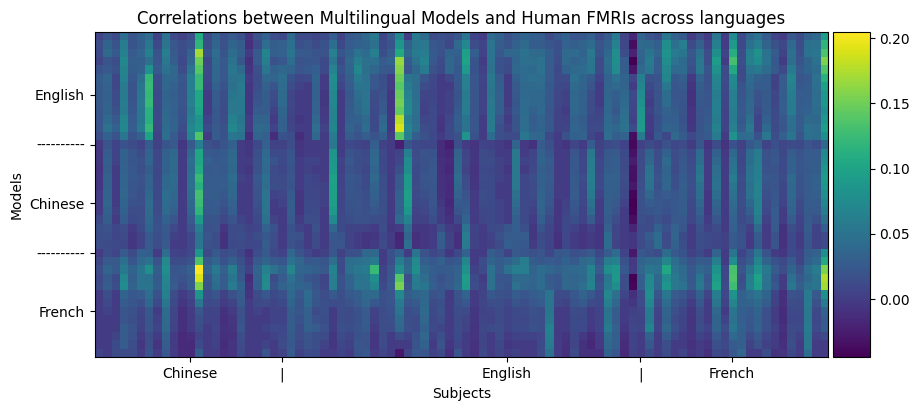

In [167]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,20))
ax.set_title('Correlations between Multilingual Models and Human FMRIs across languages')
ax.set_yticks([7, 13, 20, 26, 33], ['English', '----------', 'Chinese', '----------', 'French'])
ax.set_xticks([11, 22, 49 ,65, 76], ['Chinese', '|', 'English', '|', 'French'])
ax.set_xlabel('Subjects')
ax.set_ylabel('Models')
ax.imshow(F_M_Correlations.T)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(F_M_Correlations.T, cmap='viridis')
cbar = plt.colorbar(im, cax)

Check that values visualized are significant.

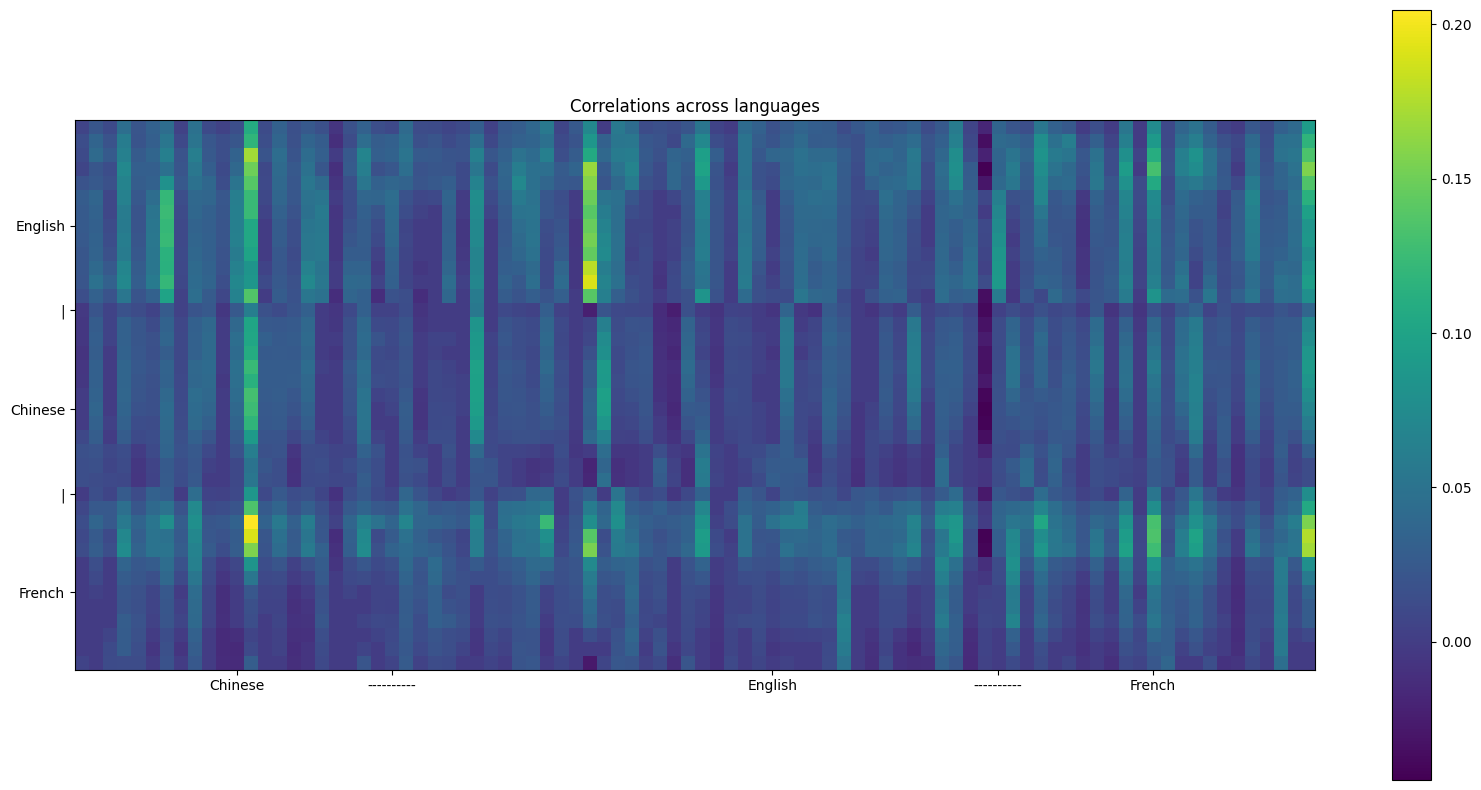

In [109]:
F_M_Correlations[F_M_pvalues > 0.05] = 0
fig, ax = plt.subplots(figsize=(10,20))
ax.set_title('Correlations across languages')
ax.set_yticks([7, 13, 20, 26, 33], ['English', '|', 'Chinese', '|', 'French'])
ax.set_xticks([11, 22, 49 ,65, 76], ['Chinese', '----------', 'English', '----------', 'French'])
ax.set_xlabel('Subjects')
ax.set_ylabel('Models')
ax.imshow(F_M_Correlations.T)
im = ax.imshow(F_M_Correlations.T, cmap='viridis')
cbar = plt.colorbar(im)

In [110]:
mean_values_FM = []
for x,y in [[0,12], [13,25], [26,38]]:
    for m,n,  in [[0,22], [23,65], [66,87]]:
        mean_values_FM.append(np.mean(Correlations_filterd[x:y,m:n]))
mean_values_FM = np.array(mean_values_FM).reshape(3,3)

In [117]:
df_FM = pd.DataFrame(mean_values_FM, index=['Model English', 'Model Chinese', 'Model French'], columns=['SUBJ Chinese', 'SUBJ English', 'SUBJ French'])
print(df_FM)

               SUBJ Chinese  SUBJ English  SUBJ French
Model English      0.091377      0.078545     0.058576
Model Chinese      0.092679      0.090230     0.071162
Model French       0.084493      0.095376     0.068174


### Block average analysis

In [ ]:
block_values_FM = []
for x,y in [[0,4], [5,12], [13,22],[23,25], [26,30], [31,38]]:
    for m,n,  in [[0,22], [23,65], [66,87]]:
        block_values_FM.append(np.mean(Correlations_filterd[x:y,m:n]))
block_values_FM = np.array(block_values_FM).reshape(6,3)

# 5. Details of Results

In [47]:
# 'EN' , 'CN', 'FR'
lang = 'EN'
# 0 - 61
text_chunck = 13

if lang == 'EN':
    print(text_bins_EN[0][text_chunck + 4]['sentences'])
elif lang == 'CN':
    print(text_bins_CN[0][text_chunck + 4]['sentences'])
elif lang == 'FR':
    print(text_bins_FR[0][text_chunck + 4]['sentences'])

the first night i went to sleep on the sand a thousand miles from any human habitation. i was more isolated than a shipwrecked sailor on a raft in the middle of the ocean. 


In [48]:
print(RSAs_Model.keys())
print(RSAs_FMRI.keys())

dict_keys(['EN_0', 'EN_1', 'EN_2', 'EN_3', 'EN_4', 'EN_5', 'EN_6', 'EN_7', 'EN_8', 'EN_9', 'EN_10', 'EN_11', 'EN_12', 'CN_0', 'CN_1', 'CN_2', 'CN_3', 'CN_4', 'CN_5', 'CN_6', 'CN_7', 'CN_8', 'CN_9', 'CN_10', 'CN_11', 'CN_12', 'FR_0', 'FR_1', 'FR_2', 'FR_3', 'FR_4', 'FR_5', 'FR_6', 'FR_7', 'FR_8', 'FR_9', 'FR_10', 'FR_11', 'FR_12'])
dict_keys(['CN002', 'CN003', 'CN004', 'CN006', 'CN007', 'CN008', 'CN009', 'CN010', 'CN013', 'CN014', 'CN015', 'CN016', 'CN017', 'CN020', 'CN021', 'CN023', 'CN025', 'CN027', 'CN028', 'CN029', 'CN030', 'CN032', 'CN036', 'EN057', 'EN058', 'EN059', 'EN061', 'EN062', 'EN063', 'EN065', 'EN067', 'EN068', 'EN069', 'EN070', 'EN072', 'EN073', 'EN074', 'EN075', 'EN076', 'EN077', 'EN078', 'EN079', 'EN081', 'EN082', 'EN083', 'EN084', 'EN086', 'EN087', 'EN088', 'EN089', 'EN091', 'EN092', 'EN094', 'EN095', 'EN096', 'EN097', 'EN098', 'EN099', 'EN101', 'EN103', 'EN105', 'EN108', 'EN109', 'EN110', 'EN113', 'EN114', 'FR001', 'FR002', 'FR003', 'FR004', 'FR005', 'FR006', 'FR007',

# 6. Sentiment Analysis

In [49]:
# Load text chuncks for all languages
file_path_T1 = './text_data/CN_chunk_data_chunk_size_2_sentiment.pickle'
file_path_T2 = './text_data/EN_chunk_data_chunk_size_2_sentiment.pickle'
file_path_T3 = './text_data/FR_chunk_data_chunk_size_2_sentiment.pickle'
with open(file_path_T1, 'rb') as f:
            text_chunks_CN_sent = pickle.load(f)
with open(file_path_T2, 'rb') as f:
            text_chunks_EN_sent = pickle.load(f)
with open(file_path_T3, 'rb') as f:
            text_chunks_FR_sent = pickle.load(f)

In [51]:
print(text_chunks_CN_sent)
print(text_chunks_EN_sent)
print(text_chunks_FR_sent)

[[{'sentences': '当 我 还 只有 六 岁 的 时候 在 一 本 描写 原始 森林 的 名 叫 真实 的 故事 的 书 中 看到 了 一 幅 精彩 的 插画. 画 的 是 一 条 蟒蛇 正在 吞食 一 只 大 野兽. ', 'onset': 0.0, 'offset': 11.3, 'section': 1, 'sentiment': {'label': 'positive', 'score': 0.9882444143295288}}, {'sentences': '页头 上 就 是 那 幅 画 的 摹本. 这 本 书 中 写道 这些 蟒蛇 把 它们 的 猎获物 不 加 咀嚼 地 囫囵 吞 下 尔后 就 不 能 再 动弹 了. ', 'onset': 12.11, 'offset': 22.09, 'section': 1, 'sentiment': {'label': 'positive', 'score': 0.9088952541351318}}, {'sentences': '它们 就 在 长长 的 六 个 月 的 睡眠 中 消化 这些 食物. 当时 我 对 丛林 中 的 奇遇 想 得 很 多. ', 'onset': 22.83, 'offset': 30.03, 'section': 1, 'sentiment': {'label': 'positive', 'score': 0.9879239201545715}}, {'sentences': '于是 我 也 用 彩色 铅笔 画 出 了 我 的 第一 幅 图画. 我 的 第一 号 作品 它 是 这样 的. ', 'onset': 30.68, 'offset': 37.38, 'section': 1, 'sentiment': {'label': 'positive', 'score': 0.9898195862770081}}, {'sentences': '我 把 我 的 这 幅 杰作 拿 给 大人 看. 我 问 他们 我 的 画 是 不 是 叫 他们 害怕. ', 'onset': 38.73, 'offset': 44.0, 'section': 1, 'sentiment': {'label': 'negative', 'score': 0.982913315296173

# 7. Monolanguage Models

In [118]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_Monolingual_Models_big.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs_Monolingual_Models = {}
for key, value in RSAs_list.items():
    RSAs_Monolingual_Models[key] = np.array(value)

In [119]:
languages = ['EN','CN', 'FR']
N_RSAs = len(RSAs_Monolingual_Models)
M_Model_Correlations = np.zeros((N_RSAs, N_RSAs))
M_Model_pvalues = np.zeros((N_RSAs, N_RSAs))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs_Monolingual_Models.keys()):
    for j, subj_b in enumerate(RSAs_Monolingual_Models.keys()):
        rsa_1 = RSAs_Monolingual_Models[subj_a]
        rsa_2 = RSAs_Monolingual_Models[subj_b]
        M_Model_Correlations[i,j], M_Model_pvalues[i,j] = rsa_correlation(rsa_1, rsa_2)
        l1_idx = int(i / 13)
        l2_idx = int(j / 13)
        layer1_idx = i % 13
        layer2_idx = j % 13
        print(f"Pearson correlation coefficient between {languages[l1_idx]} {layer1_idx} and {languages[l2_idx]} {layer2_idx}: {M_Model_Correlations[i,j]}, pvalue: {M_Model_pvalues[i,j]}")

Pearson correlation coefficient between EN 0 and EN 0: 0.9999999999999911, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 1: 0.723049363486779, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 2: 0.570068928033788, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 3: 0.5872307063298662, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 4: 0.5031687308317835, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 5: 0.36050711444182104, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 6: 0.3957699832484112, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 7: 0.3476981392392996, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 8: 0.31462922022301976, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 9: 0.2436922085084044, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 10: 0.20625928464296042, pvalue: 0.0
Pearson correlation coefficient between E

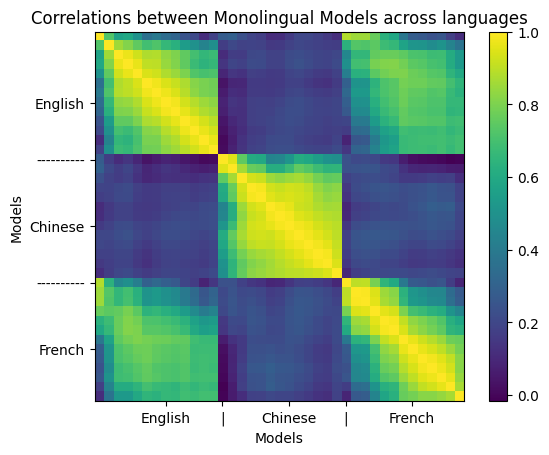

In [165]:
fig, ax = plt.subplots()
ax.set_title('Correlations between Monolingual Models across languages')
ax.set_xticks([7, 13, 20, 26, 33], ['English', '|', 'Chinese', '|', 'French'])
ax.set_yticks([7, 13, 20, 26, 33], ['English', '----------', 'Chinese', '----------', 'French'])
ax.set_xlabel('Models')
ax.set_ylabel('Models')
ax.imshow(M_Model_Correlations)
im = ax.imshow(M_Model_Correlations, cmap='viridis')
cbar = plt.colorbar(im)

In [170]:
mean_values_Model_M = []
for x,y in [[0,12], [13,25], [26,38]]:
    for m,n,  in [[0,12], [13,25], [26,38]]:
        mean_values_Model_M.append(np.mean(M_Model_Correlations[x:y,m:n]))
mean_values_Model_M = np.array(mean_values_Model).reshape(3,3)

In [171]:
df_Model_M = pd.DataFrame(mean_values_Model_M, index=['English', 'Chinese', 'French'], columns=['English', 'Chinese', 'French'])
print(df_Model_M)

          English   Chinese    French
English  0.527238  0.127026  0.214610
Chinese  0.127026  0.704803  0.094395
French   0.214610  0.094395  0.565435


In [121]:
languages = ['EN','CN', 'FR']
N_RSAs = len(RSAs_Monolingual_Models)
C_Model_Correlations = np.zeros((N_RSAs, N_RSAs))
C_Model_pvalues = np.zeros((N_RSAs, N_RSAs))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs_Monolingual_Models.keys()):
    for j, subj_b in enumerate(RSAs_Model.keys()):
        rsa_1 = RSAs_Monolingual_Models[subj_a]
        rsa_2 = RSAs_Model[subj_b]
        C_Model_Correlations[i,j], C_Model_pvalues[i,j] = rsa_correlation(rsa_1, rsa_2)
        l1_idx = int(i / 13)
        l2_idx = int(j / 13)
        layer1_idx = i % 13
        layer2_idx = j % 13
        print(f"Pearson correlation coefficient between {languages[l1_idx]} {layer1_idx} and {languages[l2_idx]} {layer2_idx}: {C_Model_Correlations[i,j]}, pvalue: {C_Model_pvalues[i,j]}")

Pearson correlation coefficient between EN 0 and EN 0: 0.9719011881031635, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 1: 0.6509645248010664, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 2: 0.6464439463199108, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 3: 0.6198068416675553, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 4: 0.42010772507869365, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 5: 0.21960951735819237, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 6: 0.1726452849616507, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 7: 0.09046373967244523, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 8: 0.08380202556275199, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 9: 0.052991484454904064, pvalue: 7.481832437432444e-187
Pearson correlation coefficient between EN 0 and EN 10: 0.03446165210067379, pvalue: 4.273892231388434e-8

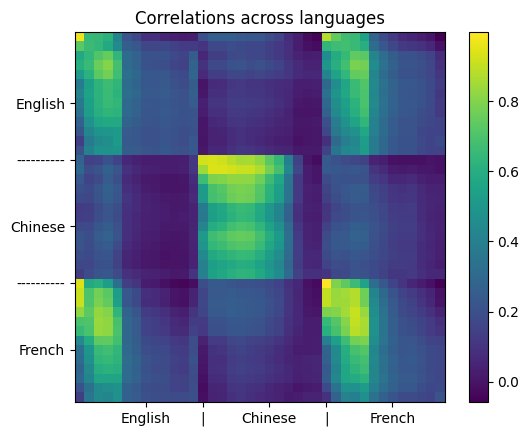

In [122]:
plt.figure(42)
plt.title('Correlations across languages')
plt.xticks([7, 13, 20, 26, 33], ['English', '|', 'Chinese', '|', 'French'])
plt.yticks([7, 13, 20, 26, 33], ['English', '----------', 'Chinese', '----------', 'French'])
plt.imshow(C_Model_Correlations)
plt.colorbar()

In [123]:
N_subjects = len(RSAs_FMRI) 
N_layers = len(RSAs_Monolingual_Models) 
MMF_Correlations = np.zeros((N_subjects, N_layers))
MMF_pvalues = np.zeros((N_subjects, N_layers))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs_FMRI.keys()):
    for j, subj_b in enumerate(RSAs_Monolingual_Models.keys()):
        rsa_1 = RSAs_FMRI[subj_a]
        rsa_2 = RSAs_Monolingual_Models[subj_b]
        min_time = min(len(rsa_1), len(rsa_2))
        MMF_Correlations[i,j], MMF_pvalues[i,j] = rsa_correlation(rsa_1[:min_time, :min_time], rsa_2[:min_time, :min_time])
        print(f"Pearson correlation coefficient between {subj_a} and {subj_b}: {MMF_Correlations[i,j]}, pvalue: {MMF_pvalues[i,j]}")

Pearson correlation coefficient between CN002 and EN_bert-base-uncased_0: 0.009630753087796689, pvalue: 1.1911277646812366e-07
Pearson correlation coefficient between CN002 and EN_bert-base-uncased_1: 0.038289056012501904, pvalue: 1.9309484549394982e-98
Pearson correlation coefficient between CN002 and EN_bert-base-uncased_2: 0.03336889509774518, pvalue: 3.2749843437239894e-75
Pearson correlation coefficient between CN002 and EN_bert-base-uncased_3: 0.03075428888143038, pvalue: 3.677738717528983e-64
Pearson correlation coefficient between CN002 and EN_bert-base-uncased_4: 0.03661681882161816, pvalue: 3.450164251361012e-90
Pearson correlation coefficient between CN002 and EN_bert-base-uncased_5: 0.04234460157813632, pvalue: 5.550425658228251e-120
Pearson correlation coefficient between CN002 and EN_bert-base-uncased_6: 0.04462298865020544, pvalue: 4.921429944349752e-133
Pearson correlation coefficient between CN002 and EN_bert-base-uncased_7: 0.04349021338792528, pvalue: 1.8490593146002

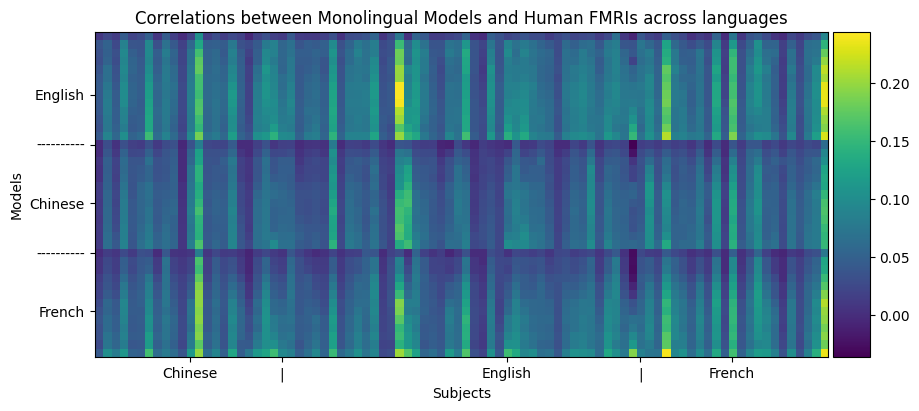

In [168]:
MMF_Correlations[MMF_pvalues > 0.05] = 0
fig, ax = plt.subplots(figsize=(10,20))
ax.set_title('Correlations between Monolingual Models and Human FMRIs across languages')
ax.set_yticks([7, 13, 20, 26, 33], ['English', '----------', 'Chinese', '----------', 'French'])
ax.set_xticks([11, 22, 49 ,65, 76], ['Chinese', '|', 'English', '|', 'French'])
ax.set_xlabel('Subjects')
ax.set_ylabel('Models')
ax.imshow(MMF_Correlations.T)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(MMF_Correlations.T, cmap='viridis')
cbar = plt.colorbar(im, cax)

In [129]:
mean_values_FMM = []
for x,y in [[0,12], [13,25], [26,38]]:
    for m,n,  in [[0,22], [23,65], [66,87]]:
        mean_values_FMM.append(np.mean(MMF_Correlations.T[x:y,m:n]))
mean_values_FMM = np.array(mean_values_FMM).reshape(3,3)

In [130]:
df_FM = pd.DataFrame(mean_values_FMM, index=['Model English', 'Model Chinese', 'Model French'], columns=['SUBJ Chinese', 'SUBJ English', 'SUBJ French'])
print(df_FM)

               SUBJ Chinese  SUBJ English  SUBJ French
Model English      0.064453      0.068552     0.068945
Model Chinese      0.047226      0.046250     0.055364
Model French       0.052761      0.051888     0.060188
